## **Exercise 1c:** 
### **Multi-arm bandit problem - Tradeoff between exloration and exloitation**
#### Week 8: Reinforcement Learning

The **multi-armed bandit problem** is a classical reinforcement learning problem. It describes problems in which a fixed limited set of resources between competing (alternative) choices in a way that maximizes their expected gain, when each choice's properties are only partially known at the time of allocation, and may become better understood as time passes or by allocating resources to the choice.

This is the original form of the k-armed bandit problem, so named by analogy to a slot machine, or “one-armed bandit,” except that it has k levers instead of one. Each action selection is like a play of one of the slot machine’s levers, and the rewards are the payoffs for hitting the jackpot.
In the problem, each machine provides a random reward from a probability distribution specific to that machine, that is not known a-priori. The objective of the gambler is to maximize the sum of rewards earned through a sequence of lever pulls.
The crucial tradeoff the gambler faces at each trial is between **exploitation** of the machine that has the highest expected payoff and **exploration** to get more information about the expected payoffs of the other machines.


https://en.wikipedia.org/wiki/Multi-armed_bandit  
Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. MIT press, 2018.

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd 

# Set font sizes for plotting
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [2]:
# Some function for plotting and visualizing the results.

def plot_average_rewards(bandit_reward_list, legend_list, title):

    """
    Plot the average rewards (averaged over all episodes) per iteration of a list of bandits in one figure.

    bandit_reward_list :    list of np arrays of length iter
    legend_list :           list of method names for legend
    """

    plt.figure(figsize=(12,8))
    for i in range(len(bandit_reward_list)):
        plt.plot(bandit_reward_list[i], label=legend_list[i])
    plt.legend(bbox_to_anchor=(1.3, 0.5))
    plt.xlabel("Iterations")
    plt.ylabel("Average Reward")
    plt.title(title, fontsize=20)
    plt.show()


def plot_selected_actions(bandit_action_list, legend_list, title):

    """
    Plot how often the actions have been selected by each algorithm in a bar plot.

    bandit_action_list :    list of np arrays of length iter
    legend_list :           list of method names for legend
    """

    color = ['b', 'g', 'r', 'm', 'k']
    bins = np.linspace(0, k-1, k)

    plt.figure(figsize=(12,8))
    for i in range(len(bandit_action_list)):
        plt.bar(bins + i*0.33, bandit_action_list[i], 
                width = 0.33, color=color[i], 
                label=legend_list[i])
    plt.legend(bbox_to_anchor=(1.2, 0.5))
    plt.xlim([0,k])
    plt.title(title, fontsize=20)
    plt.xlabel("Action")
    plt.ylabel("Number of Actions Taken")
    plt.show()

    opt_per = np.array(bandit_action_list) / iters * 100
    df = pd.DataFrame(opt_per, index=legend_list,
                    columns=["a = " + str(x) for x in range(0, k)])
    print("Percentage of actions selected:")
    print(df)


def plot_arm_average_reward(ax, rewards_arm, reward_true, title):

    """
    Plot the average rewards (averaged over all iterations) for all arms of a list of bandits in one figure.

    ax :            axis for plotting
    rewards_arm :   list of np arrays of length iter, estimated rewards for all arms at each iteration
    reward_true :   true reward for each arm     
    title :         method name
    """

    colors = ['blue', 'purple', 'green', 'orange', 'red']
    for i in range(k):
        ax.plot(rewards_arm[:,i], label=f'M{i} estimated', color=colors[i])
        ax.axhline(reward_true[i] , label=f'M{i} true', color=colors[i], linestyle='--')
    ax.set_title(title)
    ax.legend(loc='upper right')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Value Estimate')

The class `MultiArmedBandit` implements the multi-armed bandit problem with *k* arms.  
Make yourself familiar with the code.

In [3]:
class MultiArmedBandit():

    """
    multi-bandit problem

    Inputs
    k:      number of arms (int)
    eps:    probability of random action 0 < eps < 1 (float)
    iters:  number of steps (int)
    mu:     average rewards for each of the k arms.
            'random': rewards selected from normal distribution with mean=0.
            'sequence': rewards selected from normal distribution with mean from 0 to k-1 (ordered).
            list or array of length k: user-defined values for the means.
    """


    def __init__(self, k, eps, iters, mu='random'):
        # Number of arms
        self.k = k

        # Search probability
        self.eps = eps
        # Number of iterations
        self.iters = iters
        # Step count
        self.t = 0
        # Step count for each arm
        self.k_t = np.zeros(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_mean_reward = np.zeros(k)
        # self.k_rewards = np.zeros((k,iters))
        self.k_rewards = []

        if type(mu) == list or type(mu).__module__ == np.__name__:
            # User-defined averages            
            self.mu = np.array(mu)
        elif mu == 'random':
            # Draw means from probability distribution
            self.mu = np.random.normal(0, 1, k)
        elif mu == 'sequence':
            # Increase the mean for each arm by one
            self.mu = np.linspace(0, k-1, k)
    
    def pull(self):
        
        # action selection:

        # Generate random number
        p = np.random.rand()

        # epsilon-greedy action
        if self.eps == 0 and self.t == 0:
            a = np.random.choice(self.k)
        elif p < self.eps:
            # Randomly select an action
            a = np.random.choice(self.k)
        else:
            # Take greedy action
            a = np.argmax(self.k_mean_reward)
        

        # reward for action a (sampled from reward distribution of action a)
        reward = np.random.normal(self.mu[a], 1)
        self.reward[self.t] = reward

        # Update counts
        self.t += 1  # total count
        self.k_t[a] += 1  # count for each arm

        # Update total reward
        self.mean_reward = self.mean_reward + ( reward - self.mean_reward) / self.t

        # Update reward for arm a (selected in the current pull)
        self.k_mean_reward[a] = self.k_mean_reward[a] + ( reward - self.k_mean_reward[a]) / self.k_t[a]
        self.k_rewards.append(copy.copy(self.k_mean_reward))


    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward

    
    def reset(self):
        # Resets results while keeping settings
        self.t = 0
        self.k_t = np.zeros(self.k)
        self.mean_reward = 0
        self.reward = np.zeros(self.iters)
        self.k_mean_reward = np.zeros(self.k)
        self.k_rewards = np.zeros((self.k,iters))


### **Exercise 2(a)**
Briefly describe the *exploration-exploitation* dilemma. How is this addressed in the class `MultiArmedBandit`?

--------------------------------------------------------------------------
Run experiments with $1000$ test runs (episodes) of the Multi-armed bandit with $\epsilon=0$, $\epsilon=0.1$, $\epsilon=0.01$.

In [4]:
"""
For each of the three bandits, we set k=10, run 1,000 steps for each episode and run 1,000 episodes. 
After each episode, we will reset the bandits and copy the averages across the different bandits to keep things
consistent.
"""

k = 10
iters = 1000

eps_0_rewards = np.zeros(iters)
eps_01_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)
eps_1_1_rewards = np.zeros(iters)

episodes = 1000
# Run experiments
for i in range(episodes):
    
    # Initialize three bandits with eps=0, eps=0.1, and eps=0.01 
    eps_0 = MultiArmedBandit(k, 0, iters)
    eps_01 = MultiArmedBandit(k, 0.01, iters, eps_0.mu.copy())
    eps_1 = MultiArmedBandit(k, 0.1, iters, eps_0.mu.copy())
    eps_1_1 = MultiArmedBandit(k, 1, iters, eps_0.mu.copy())
    
    # Run experiments
    eps_0.run()
    eps_01.run()
    eps_1.run()
    eps_1_1.run()
    
    # Update long-term averages
    eps_0_rewards = eps_0_rewards + (
        eps_0.reward - eps_0_rewards) / (i + 1)
    eps_01_rewards = eps_01_rewards + (
        eps_01.reward - eps_01_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (
        eps_1.reward - eps_1_rewards) / (i + 1)
    eps_1_1_rewards = eps_1_1_rewards + (
        eps_1_1.reward - eps_1_1_rewards) / (i + 1)
    


Figure 1

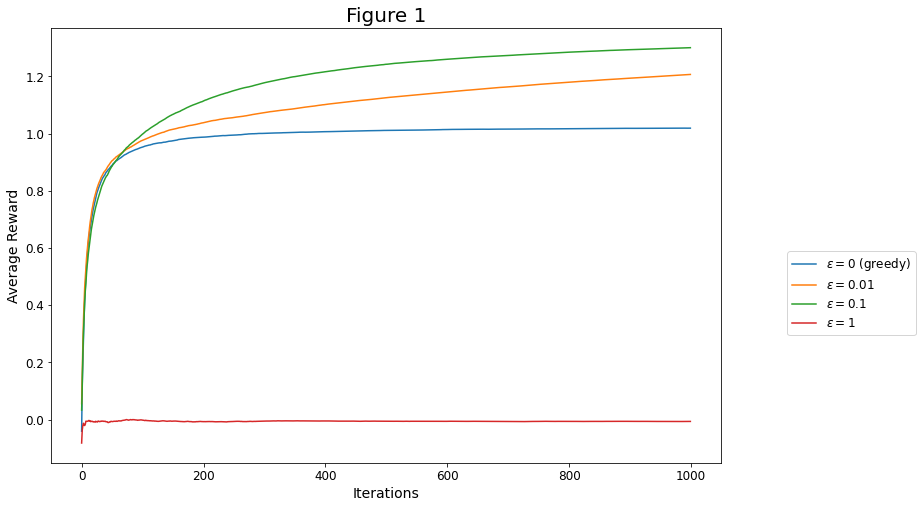

In [5]:
# Average $\epsilon-greedy$ Rewards after 1000 Episodes
plot_average_rewards([eps_0_rewards,eps_01_rewards,eps_1_rewards, eps_1_1_rewards], 
                     ["$\epsilon=0$ (greedy)", "$\epsilon=0.01$", "$\epsilon=0.1$", "$\epsilon=1$"],
                     "Figure 1")

### **Exercise 2(b)**

Describe and discuss the results which are displayed in Figure 1.

------------------------------------------------------------------------------------
Repeat the experiment with `k=4` and `mu='sequence'`.  


In [7]:
k = 4
iters = 1000

eps_0_rewards = np.zeros(iters)
eps_01_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)

eps_0_selection = np.zeros(k)
eps_01_selection = np.zeros(k)
eps_1_selection = np.zeros(k)

episodes = 1000
# Run experiments
for i in range(episodes):

    # Initialize three bandits with eps=0, eps=0.1, and eps=0.01, and mu='sequence'
    eps_0 = MultiArmedBandit(k, 0, iters, mu='sequence')
    eps_01 = MultiArmedBandit(k, 0.01, iters, eps_0.mu.copy())
    eps_1 = MultiArmedBandit(k, 0.1, iters, eps_0.mu.copy())
    
    # Run experiments
    eps_0.run()
    eps_01.run()
    eps_1.run()
    
    # Update long-term averages
    eps_0_rewards = eps_0_rewards + (
        eps_0.reward - eps_0_rewards) / (i + 1)
    eps_01_rewards = eps_01_rewards + (
        eps_01.reward - eps_01_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (
        eps_1.reward - eps_1_rewards) / (i + 1)

    # Average actions per episode
    eps_0_selection = eps_0_selection + (
        eps_0.k_t - eps_0_selection) / (i + 1)
    eps_01_selection = eps_01_selection + (
        eps_01.k_t - eps_01_selection) / (i + 1)
    eps_1_selection = eps_1_selection + (
        eps_1.k_t - eps_1_selection) / (i + 1)
    


Figure 2

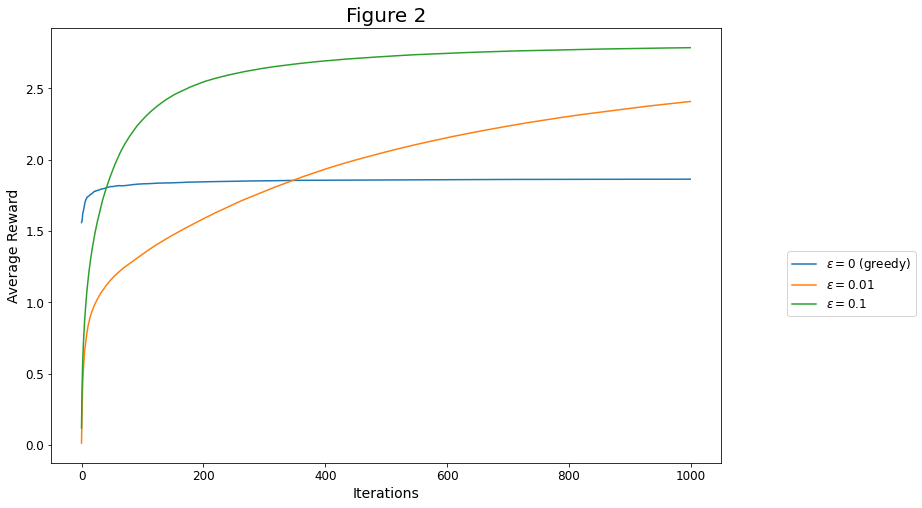

In [8]:
# Average $\epsilon-greedy$ Rewards after 1000 Episodes
plot_average_rewards([eps_0_rewards,eps_01_rewards,eps_1_rewards], 
                     ["$\epsilon=0$ (greedy)", "$\epsilon=0.01$", "$\epsilon=0.1$"],
                     "Figure 2")

### **Exercise 2(c) (i)**
Compare Figure 2 to Figure 1. Which differences do you observe?


-------------------------
Figure 3

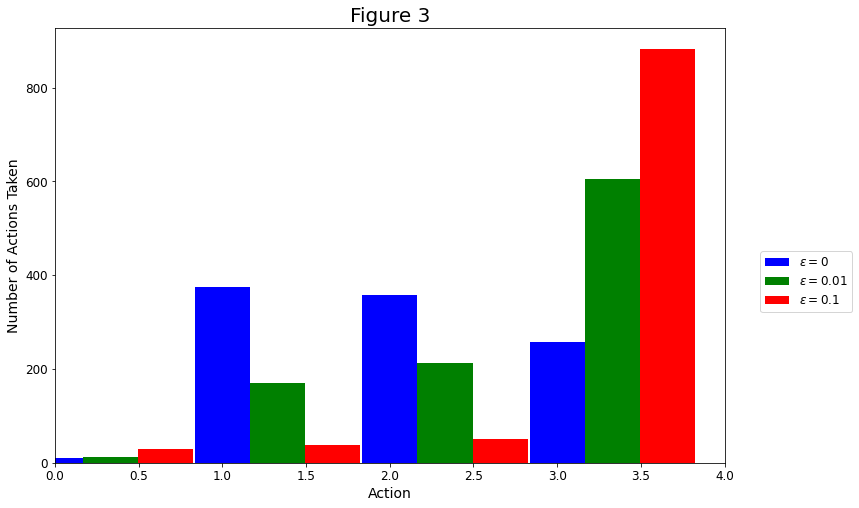

Percentage of actions selected:
                  a = 0    a = 1    a = 2    a = 3
$\epsilon=0$     1.0585  37.4384  35.7043  25.7988
$\epsilon=0.01$  1.3095  17.0020  21.2018  60.4867
$\epsilon=0.1$   2.8572   3.8558   4.9762  88.3108


In [9]:
# Actions Selected by Each Algorithm
plot_selected_actions([eps_0_selection, eps_01_selection, eps_1_selection], 
                      ['$\epsilon=0$', '$\epsilon=0.01$', '$\epsilon=0.1$'],
                      "Figure 3")

### **Exercise 2(c) (ii)**
Compare how often the correct action is taken in each of the three models (illustrated in Figure 3). Describe and discuss the results.

-------------------
Figure 4

Text(0.5, 0.98, 'Figure 4')

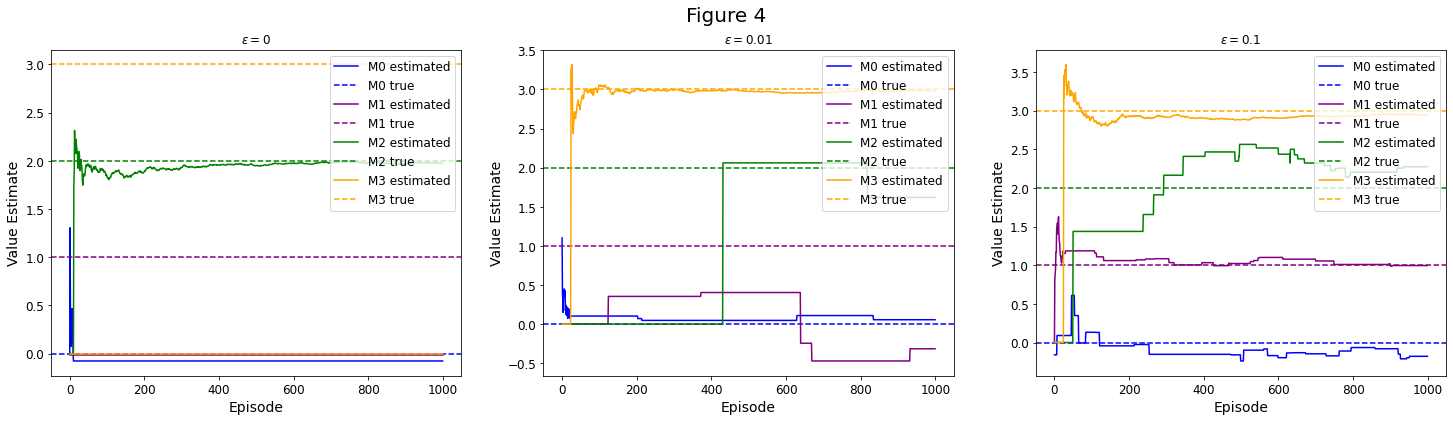

In [10]:
eps_0.k_rewards = np.array(eps_0.k_rewards)
eps_01.k_rewards = np.array(eps_01.k_rewards)
eps_1.k_rewards = np.array(eps_1.k_rewards)

fig, ax = plt.subplots(1,3,figsize=(25,6))
plot_arm_average_reward(ax[0], eps_0.k_rewards, eps_0.mu, '$\epsilon=0$')
plot_arm_average_reward(ax[1], eps_01.k_rewards, eps_01.mu, '$\epsilon=0.01$')
plot_arm_average_reward(ax[2], eps_1.k_rewards, eps_1.mu, '$\epsilon=0.1$')

fig.suptitle('Figure 4', fontsize=20)

### **Exercise 2(c) (iii)**
Figure 4 shows the average estimated rewards and the true reward for each arm of the three bandits. Compare and discuss the three subplots.

-----------------------------------------------------------------------------------------------------

An improved version of the $\epsilon$-*greedy* action selection method is $\epsilon$-*decay* action selection (implemented in class `MultiArmedBandid_decay`).  
Here, $\epsilon$ is dependent on the time step $t$, e.g., $\epsilon(t)=\frac{1}{1+t\beta}$ with $\beta<1$ (use $\beta=\frac{1}{k}$). 





In [11]:
class MultiArmBandit_decay():

    """
    k-bandit problem

    Inputs
    k:      number of arms (int)
    eps:    probability of random action 0 < eps < 1 (float)
    iters:  number of steps (int)
    mu:     average rewards for each of the k arms.
            'random': rewards selected from normal distribution with mean=0.
            'sequence': rewards selected from normal distribution with mean from 0 to k-1 (ordered).
            list or array of length k: user-defined values for the means.
    """


    def __init__(self, k, iters, mu='random'):
        # Number of arms
        self.k = k

        # Number of iterations
        self.iters = iters
        # Step count
        self.t = 0
        # Step count for each arm
        self.k_t = np.zeros(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_mean_reward = np.zeros(k)
        # self.k_rewards = np.zeros((k,iters))
        self.k_rewards = []

        if type(mu) == list or type(mu).__module__ == np.__name__:
            # User-defined averages            
            self.mu = np.array(mu)
        elif mu == 'random':
            # Draw means from probability distribution
            self.mu = np.random.normal(0, 1, k)
        elif mu == 'sequence':
            # Increase the mean for each arm by one
            self.mu = np.linspace(0, k-1, k)
    
    def pull(self):

        # action selection:

        # Generate random number
        p = np.random.rand()

        # epsilon-decay action
        if p < 1 / (1 + self.t / self.k):
            a = np.random.choice(self.k)
        else:
            # Take greedy action
            a = np.argmax(self.k_mean_reward)

        # reward for action a (sampled from reward distribution of action a)
        reward = np.random.normal(self.mu[a], 1)
        self.reward[self.t] = reward

        # Update counts
        self.t += 1
        self.k_t[a] += 1

        # Update total reward
        self.mean_reward = self.mean_reward + ( reward - self.mean_reward) / self.t

        # Update reward for arm a (selected in the current pull)
        self.k_mean_reward[a] = self.k_mean_reward[a] + ( reward - self.k_mean_reward[a]) / self.k_t[a]
        self.k_rewards.append(copy.copy(self.k_mean_reward))


    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward

    
    def reset(self):
        # Resets results while keeping settings
        self.t = 0
        self.k_t = np.zeros(self.k)
        self.mean_reward = 0
        self.reward = np.zeros(self.iters)
        self.k_mean_reward = np.zeros(self.k)
        self.k_rewards = np.zeros((self.k,iters))

### **Exercise 2(d) (i)**
In which sense does this improve the $\epsilon$-*greedy* action selection? 

------------------
Run experiments with `k=4` and three bandits.

In [12]:
k = 4
iters = 1000

eps_0_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)
eps_d_rewards = np.zeros(iters)

eps_0_selection = np.zeros(k)
eps_1_selection = np.zeros(k)
eps_d_selection = np.zeros(k)

episodes = 1000
# Run experiments
for i in range(episodes):

    # Initialize three bandits with eps=0, eps=0.1, and eps-decay
    eps_0 = MultiArmedBandit(k, 0, iters, mu='sequence')
    eps_1 = MultiArmedBandit(k, 0.1, iters, eps_0.mu.copy())
    eps_d = MultiArmBandit_decay(k, iters, eps_0.mu.copy())
    
    # Run experiments
    eps_0.run()
    eps_1.run()
    eps_d.run()
    
    # Update long-term averages
    eps_0_rewards = eps_0_rewards + (
        eps_0.reward - eps_0_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (
        eps_1.reward - eps_1_rewards) / (i + 1)
    eps_d_rewards = eps_d_rewards + (
        eps_d.reward - eps_d_rewards) / (i + 1)

    # Average actions per episode
    eps_0_selection = eps_0_selection + (
        eps_0.k_t - eps_0_selection) / (i + 1)
    eps_1_selection = eps_1_selection + (
        eps_1.k_t - eps_1_selection) / (i + 1)
    eps_d_selection = eps_d_selection + (
        eps_d.k_t - eps_d_selection) / (i + 1)


Figure 5

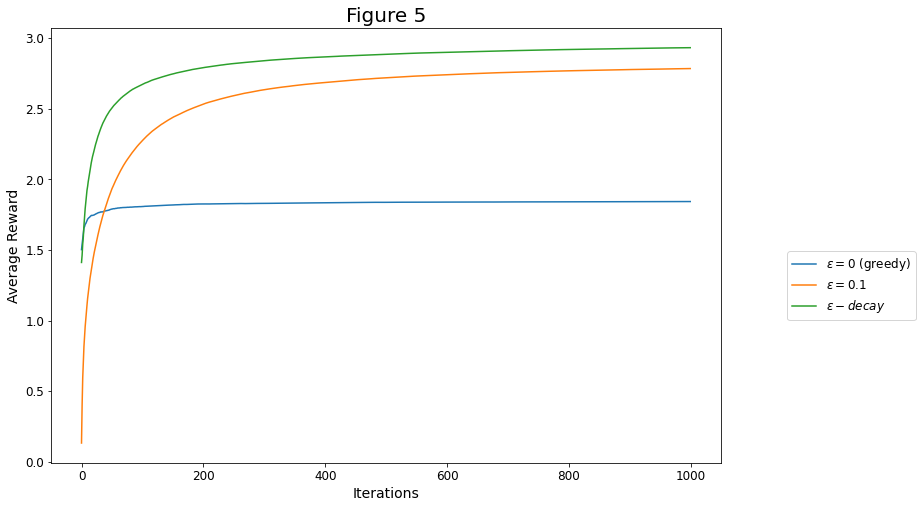

In [13]:
# Average epsilon-greedy/decay Rewards after 1000 Episodes
plot_average_rewards([eps_0_rewards,eps_1_rewards,eps_d_rewards], 
                     ["$\epsilon=0$ (greedy)", "$\epsilon=0.1$", "$\epsilon-decay$"],
                     "Figure 5")


Figure 6

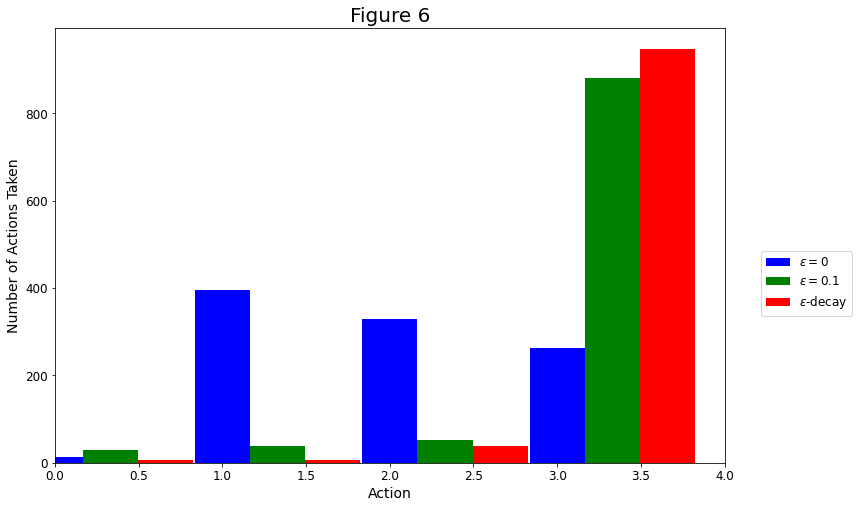

Percentage of actions selected:
                   a = 0    a = 1    a = 2    a = 3
$\epsilon=0$      1.2405  39.5709  32.9909  26.1977
$\epsilon=0.1$    2.8631   3.9289   5.1086  88.0994
$\epsilon$-decay  0.5639   0.7107   3.9385  94.7869


In [14]:
# Actions Selected by Each Algorithm
plot_selected_actions([eps_0_selection, eps_1_selection, eps_d_selection], 
                      ['$\epsilon=0$', '$\epsilon=0.1$', '$\epsilon$-decay'],
                      "Figure 6")

### **Exercise 2(d) (ii)**

Discuss the results presented in Figures 5 and 6.